# **Classificação multirrotulo de reclamações no setor financeiro**

## Importação de livrarias e dados

In [1]:
!pip install scikit-multilearn
!pip install -U deep-translator
!pip install transformers
!pip install unidecode
# !pip install json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.6 MB/s eta 0:00:00


In [2]:

#Livrarias
import pandas as pd
import numpy as np
import numpy as np
import seaborn as sn
import json
import re
import time
from unidecode import unidecode
from deep_translator import GoogleTranslator
import nltk
import pickle

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import hamming_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from transformers import BertTokenizer
from transformers import TFBertModel
from transformers import RobertaTokenizer
from transformers import TFRobertaForSequenceClassification
from transformers import GPT2Tokenizer
from transformers import TFGPT2Model
from skmultilearn.problem_transform import ClassifierChain

from sklearn.metrics import accuracy_score, classification_report

In [3]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Dataset antigo
# df = pd.read_csv('/content/drive/MyDrive/estudo/Tesis-PUC/complaints.csv')

#Dataset novo
df = pd.read_csv("/content/drive/MyDrive/estudo/Tesis-PUC/Basev1/Text_bank_start.csv")

## Análisis Exploratorio (EDA)

In [ ]:
#df= df_base.copy()

In [ ]:
df.tail(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
46422,2022-06-17,"Payday loan, title loan, or personal loan",Installment loan,Getting the loan,NaN,"On XX/XX/2022, I spoke with a loan representat...",Company has responded to the consumer and the ...,TRUIST FINANCIAL CORPORATION,TN,37211,Older American,Consent provided,Web,2022-07-01,Closed with explanation,Yes,NaN,5679603
46423,2016-11-11,Consumer Loan,Vehicle lease,Managing the loan or lease,NaN,"Simply, I returned a leased Kia to the Kia dea...",NaN,HYUNDAI CAPITAL AMERICA,AZ,85225,NaN,Consent provided,Web,2016-11-11,Closed,Yes,No,2205402
46424,2022-11-18,"Money transfer, virtual currency, or money ser...",Virtual currency,Fraud or scam,NaN,"Dear Sir / Madam, I would like to draw your at...",NaN,"Coinbase, Inc.",NaN,XXXXX,NaN,Consent provided,Web,2022-11-18,Closed with explanation,Yes,NaN,6220719


In [ ]:
df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [ ]:
#Dimensão
qtd_colunas = df.shape[1]
qtd_linhas = df.shape[0]
print(f"Quantidade de colunas: {qtd_colunas}\nQuantidade de linhas: {qtd_linhas}")

Quantidade de colunas: 18
Quantidade de linhas: 46425


In [ ]:
# Identificação de valores unicos por constantes
dic_unique = {}
for i in df.columns:
  dic_unique[i] = df[i].nunique()
dic_unique = sorted(dic_unique.items(),key=lambda x:x[1])
dic_unique

[('Consumer consent provided?', 1),
 ('Submitted via', 1),
 ('Timely response?', 2),
 ('Consumer disputed?', 2),
 ('Tags', 3),
 ('Company response to consumer', 5),
 ('Company public response', 10),
 ('Product', 18),
 ('State', 60),
 ('Sub-product', 74),
 ('Issue', 154),
 ('Sub-issue', 206),
 ('Company', 1909),
 ('Date sent to company', 2976),
 ('Date received', 2985),
 ('ZIP code', 6341),
 ('Consumer complaint narrative', 34932),
 ('Complaint ID', 46425)]

In [ ]:
#Excluiindo colunas com valores unicos e valores constantes que não eriquecem os dados
df = df[['Timely response?','Consumer disputed?','Tags','Company response to consumer',
        'Company public response','Product','State','Sub-product','Issue','Sub-issue',
        'Date received','Date sent to company','Consumer complaint narrative','Company']]

In [ ]:
# Porcentagem de valores nulos por coluna
analise_nullos = pd.DataFrame(df.isnull().sum()/df.shape[0]*100, columns=['Null_%']
             ).reset_index(names = ['Colunas']).sort_values(by=['Null_%'],ascending=False)

df = df[['Timely response?','Company response to consumer','Product','State',
         'Sub-product','Issue','Sub-issue','Date received','Date sent to company',
         'Consumer complaint narrative','Company']]

analise_nullos
# Serão deletadas as colunas que tem um porcentagem alto de valores nulos
# Colunas deletadas:
#  * 'Consumer disputed?'
#  * 'Tags'
#  * 'Company public response'

,Colunas,Null_%
2,Tags,87.110393
1,Consumer disputed?,85.858912
4,Company public response,55.569198
9,Sub-issue,25.038234
7,Sub-product,3.394723
6,State,0.911147
0,Timely response?,0.000000
3,Company response to consumer,0.000000
5,Product,0.000000
8,Issue,0.000000


In [ ]:
##Colunas delatadas por não oferecer ganho de informação conceitualmente na modelagem
# Colunas deletadas:
#  * 'Timely response?'
#  * 'Company response to consumer'
#  * 'State'
#  * 'Date sent to company'
#  * 'Company'

#  * 'Sub-product'
#  * 'Sub-issue',
#  * 'Issue',

df = df[['Date received', 'Product', 'Consumer complaint narrative']]

In [ ]:
df.head()

,Date received,Product,Consumer complaint narrative
0,2023-04-17,"Credit reporting, credit repair services, or o...",XXXX XXXX XXXX CREDIT BUREAU ; Every month I q...
1,2023-04-17,"Credit reporting, credit repair services, or o...",XXXX XXXX XXXX CREDIT BUREAU ; Every month I q...
2,2023-04-17,"Credit reporting, credit repair services, or o...",XXXX XXXX XXXX CREDIT BUREAU ; Every month I q...
3,2023-04-17,"Credit reporting, credit repair services, or o...",In accordance with the Fair Credit Reporting a...
4,2023-04-27,"Payday loan, title loan, or personal loan",Their website and statements do not tell me : ...


In [ ]:
# Identificação de quantidade de valores unicos por cada feature
dic_unique = {}
for i in df.columns:
  dic_unique[i] = df[i].nunique()
dic_unique = sorted(dic_unique.items(),key=lambda x:x[1])
dic_unique

[('Product', 18),
 ('Date received', 2985),
 ('Consumer complaint narrative', 34932)]

In [ ]:
# Identificação e armazenando valores unicos por cada feature
Valores_unicos = []
for i in df.columns:
  tupla = (i,list(df[i].unique()))
  Valores_unicos.append(tupla)
  print(i)
#print(Valores_unicos)

Date received
Product
Consumer complaint narrative


In [ ]:
Valores_unicos[0][0]

'Date received'

In [ ]:
df.head()

,Date received,Product,Consumer complaint narrative
0,2023-04-17,"Credit reporting, credit repair services, or o...",XXXX XXXX XXXX CREDIT BUREAU ; Every month I q...
1,2023-04-17,"Credit reporting, credit repair services, or o...",XXXX XXXX XXXX CREDIT BUREAU ; Every month I q...
2,2023-04-17,"Credit reporting, credit repair services, or o...",XXXX XXXX XXXX CREDIT BUREAU ; Every month I q...
3,2023-04-17,"Credit reporting, credit repair services, or o...",In accordance with the Fair Credit Reporting a...
4,2023-04-27,"Payday loan, title loan, or personal loan",Their website and statements do not tell me : ...


In [ ]:
# Contagem de target ainda nos dados sem tratamento
df[['Product','Consumer complaint narrative']].groupby('Product').count().sort_values('Consumer complaint narrative')

,Consumer complaint narrative
Product,
Virtual currency,1
Other financial service,17
Money transfers,170
Prepaid card,184
Payday loan,185
Bank account or service,445
Credit card,573
Credit reporting,817
Consumer Loan,1074


**Tradução do Target**



> Virtual currency            -> Moeda virtual
> Other financial service	    -> Outros serviços financeiros
> Prepaid card                -> cartão pré-pago
>
> Money transfers             -> transferências de dinheiro
>
> Payday loan	                -> empréstimo consignado
>
> Consumer Loan               -> empréstimo ao consumidor
>
> Bank account or service     -> Conta bancária ou serviço
>
> Payday loan, title loan, or personal loan -> Empréstimo consignado, empréstimo consignado ou empréstimo pessoal
>
> Credit card                 -> Cartão de crédito
>
> Vehicle loan or lease	      -> Empréstimo ou locação de veículo
>
> Money transfer, virtual currency, or money service -> Transferência de dinheiro, moeda virtual ou serviço de dinheiro
>
> Credit reporting            -> Relatório de crédito
>
> Student loan                -> empréstimo estudantil
>
> Checking or savings account -> Conta corrente ou poupança
>
> Credit card or prepaid card -> Cartão de crédito ou cartão pré-pago
>
> Mortgage                    -> Hipoteca
>
> Debt collection             -> cobrança de dívidas
>
> Credit reporting, credit repair services, or other personal consumer reports	- > Relatórios de crédito, serviços de reparo de crédito ou outros relatórios pessoais do consumidor

In [ ]:
############  Label's originais ############

# Virtual currency
# Other financial service
# Prepaid card
# Money transfers
# Payday loan
# Consumer Loan
# Bank account or service
# Payday loan, title loan, or personal loan
# Credit card
# Vehicle loan or lease
# Money transfer, virtual currency, or money service
# Credit reporting
# Student loan
# Checking or savings account
# Credit card or prepaid card
# Mortgage
# Debt collection
# Credit reporting, credit repair services, or other personal consumer reports

# -------------------------------------------------------------------------------------------------
############  Label's padronizadas ############

# Virtual currency
# Other financial service
# Prepaid card
# Money transfers
# Payday loan
# Consumer Loan
# Bank account | service
# Payday loan
# Credit card
# Vehicle loan or lease
# Money transfers | Virtual currency | service
# Credit reporting
# Student loan
# Bank account
# Credit card | Prepaid card
# Mortgage
# Debt collection
# Credit reporting | Other financial service

# -------------------------------------------------------------------------------------------------
############  Label's padronizadas traduzidas ############

# Virtual currency                                Moeda virtual
# Other financial service                         Outros serviços financeiros
# Prepaid card                                    Cartão Debito
# Money transfers                                 Transferências de dinheiro
# Payday loan                                     Empréstimo Pessoal
# Consumer Loan                                   Crédito ao Consumo
# Bank account | service                          Conta bancária | Serviço
# Payday loan                                     Empréstimo Pessoal
# Credit card                                     Cartão de crédito
# Vehicle loan or lease                           Empréstimo ou locação de veículos
# Money transfers | Virtual currency | service    Transferências de dinheiro | Moeda virtual | Serviço
# Credit reporting                                Relatórios de crédito
# Student loan                                    Empréstimo estudantil
# Bank account                                    Conta bancária
# Credit card | Prepaid card                      Cartão de crédito | Cartão Debito
# Mortgage                                        Hipoteca
# Debt collection                                 Cobrança de dívidas
# Credit reporting | Other financial service      Relatórios de crédito | Outros serviços financeiros

##Pre-processamento de Dados

In [ ]:
#Criando dicionario para o mapeamento dos produtos multi categoria e tradução

# dictionary_class = {"Virtual currency": "Virtual currency",
#                     "Other financial service": "Other financial service",
#                     "Prepaid card": "Prepaid card",
#                     "Money transfers": "Money transfers",
#                     "Payday loan": "Payday loan",
#                     "Consumer Loan": "Consumer loan",
#                     "Bank account or service": "Bank account | service",
#                     "Payday loan, title loan, or personal loan": "Payday loan | Consumer loan",
#                     "Credit card": "Credit card",
#                     "Vehicle loan or lease": "Vehicle loan or lease",
#                     "Money transfer, virtual currency, or money service": "Money transfers | Virtual currency | service",
#                     "Credit reporting": "Credit reporting",
#                     "Student loan": "Student loan",
#                     "Checking or savings account": "Bank account",
#                     "Credit card or prepaid card": "Credit card | Prepaid card",
#                     "Mortgage": "Mortgage",
#                     "Debt collection": "Debt collection",
#                     "Credit reporting, credit repair services, or other personal consumer reports": "Credit reporting | Other financial service"
#                     }

dictionary_class = {"Virtual currency": "Moeda virtual",
                    "Other financial service": "Outros serviços financeiros",
                    "Prepaid card": "Cartão Debito",
                    "Money transfers": "Transferências de dinheiro",
                    "Payday loan": "Empréstimo Pessoal",
                    "Consumer Loan": "Crédito ao Consumo",
                    "Bank account or service": "Conta bancária | Serviço",
                    "Payday loan, title loan, or personal loan": "Empréstimo Pessoal",
                    "Credit card": "Cartão de crédito",
                    "Vehicle loan or lease": "Empréstimo ou locação de veículos",
                    "Money transfer, virtual currency, or money service": "Transferências de dinheiro | Moeda virtual | Serviço",
                    "Credit reporting": "Relatórios de crédito",
                    "Student loan": "Empréstimo estudantil",
                    "Checking or savings account": "Conta bancária",
                    "Credit card or prepaid card": "Cartão de crédito | Cartão Debito",
                    "Mortgage": "Hipoteca",
                    "Debt collection": "Cobrança de dívidas",
                    "Credit reporting, credit repair services, or other personal consumer reports": "Relatórios de crédito | Outros serviços financeiros"
                    }

#Renomear os nomes da label
df["New_product_class"] = df["Product"].replace(dictionary_class)

In [ ]:
df.head()

,Date received,Product,Consumer complaint narrative,New_product_class
0,2023-04-17,"Credit reporting, credit repair services, or o...",XXXX XXXX XXXX CREDIT BUREAU ; Every month I q...,Relatórios de crédito | Outros serviços financ...
1,2023-04-17,"Credit reporting, credit repair services, or o...",XXXX XXXX XXXX CREDIT BUREAU ; Every month I q...,Relatórios de crédito | Outros serviços financ...
2,2023-04-17,"Credit reporting, credit repair services, or o...",XXXX XXXX XXXX CREDIT BUREAU ; Every month I q...,Relatórios de crédito | Outros serviços financ...
3,2023-04-17,"Credit reporting, credit repair services, or o...",In accordance with the Fair Credit Reporting a...,Relatórios de crédito | Outros serviços financ...
4,2023-04-27,"Payday loan, title loan, or personal loan",Their website and statements do not tell me : ...,Empréstimo Pessoal


In [ ]:
df.shape

(46425, 4)

In [ ]:
#deletando registros duplicados e etualizando o index
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,Date received,Product,Consumer complaint narrative,New_product_class
0,2023-04-17,"Credit reporting, credit repair services, or o...",XXXX XXXX XXXX CREDIT BUREAU ; Every month I q...,Relatórios de crédito | Outros serviços financ...
1,2023-04-17,"Credit reporting, credit repair services, or o...",In accordance with the Fair Credit Reporting a...,Relatórios de crédito | Outros serviços financ...
2,2023-04-27,"Payday loan, title loan, or personal loan",Their website and statements do not tell me : ...,Empréstimo Pessoal
3,2023-04-17,"Credit reporting, credit repair services, or o...",My name is XXXX XXXX this complaint is not mad...,Relatórios de crédito | Outros serviços financ...
4,2023-06-03,Credit card or prepaid card,-I was approved for a XXXX XXXXXXXX Bank of Am...,Cartão de crédito | Cartão Debito


In [ ]:
# Limpeza da feature que contem o texto
def limpeza_texto(text):
    # Padrão de emojis Unicode
    # emoji_pattern = re.compile("["
                              #  u"\U0001F600-\U0001F64F"  # emoticons
                              #  u"\U0001F300-\U0001F5FF"  # símbolos & pictogramas
                              #  u"\U0001F680-\U0001F6FF"  # transporte e símbolos de mapas
                              #  u"\U0001F700-\U0001F77F"  # símbolos alquímicos
                              #  u"\U0001F780-\U0001F7FF"  # símbolos georgianos suplementares
                              #  u"\U0001F800-\U0001F8FF"  # sinais de pontuação de sinais de fala
                              #  u"\U0001F900-\U0001F9FF"  # símbolos suplementares chineses
                              #  u"\U0001FA00-\U0001FA6F"  # símbolos de domínio de CJK
                              #  u"\U0001FA70-\U0001FAFF"  # símbolos de objetos CJK
                              #  u"\U00002702-\U000027B0"  # símbolos de estilo antigo
                              #  u"\U000024C2-\U0001F251"
                              #  "]+", flags=re.UNICODE)
#
    #Substituir emojis por uma string vazia
    # texto_sem_emojis = emoji_pattern.sub(r'', text)

    # Removendo o formato <U42 usando replace
    texto_formato_1 = text.replace('<U42', '')
    patterns = [r'\\[\w-]+', r'\\\.', r'\\ ', r'\\',
               r'[^\w\s]']
    combined_pattern = '|'.join(patterns)
    replaced_text = re.sub(combined_pattern, '', texto_formato_1)
    try:
      # Convertendo a sequência Unicode para uma string legível
      texto_decoded = replaced_text.encode('utf-8').decode('unicode_escape')
    except UnicodeDecodeError as e:
      print("Erro ao decodifar: ", e )
      print(text )
      #print()
    # Removendo o formato <U42 usando replace
    texto_formatado_2 = texto_decoded.replace('<U42', '')

    # Remoção de caracteres especiais usando expressão regular
    # -texto_sem_carater_especial = re.sub(r'[^\w\s]', '', texto_formatado_2)
    # Limpeza de caracteres especiais e quebras de linha
    texto_limpo = re.sub(r'\s+', ' ', texto_formatado_2)
    texto_limpo = re.sub(r'[^a-zA-Z0-9\s]', '', texto_limpo)
    texto_limpo = re.sub(r'\b\w*XX\w*\b', '', texto_limpo)
    texto_limpo = texto_limpo.lower()
    #print(texto_sem_carater_especial)
    return texto_limpo


unicode_string = "<U42Hello, XXcantera this is a <U42test texto! 😊🚀 string<U42> texto ColicXXao! 😊🚀"
texto_sem_emojis = limpeza_texto(unicode_string)

print('Resultado final da função:', texto_sem_emojis)

# print("Texto original:", unicode_string)
# print("Texto sem emojis:", texto_sem_emojis)
# print("Texto após remoção de <U42:", cleaned_string)
# print("Texto após remoção dos caraters especiais:",texto_sem_carater_especial)

# Execução de Limpeza de Texto
df['Consumer complaint narrative_clean'] = df['Consumer complaint narrative'].\
                                            apply(lambda x: limpeza_texto(x))

# Execução de limpeza de Labels
df['New_product_class_clean'] = df['New_product_class'].apply(lambda x:unidecode(x))
#comparação de resultado
linha = 6678
print(df['Consumer complaint narrative'][linha])
print(df['Consumer complaint narrative_clean'][linha])

In [ ]:
# Criação de novas colunas multilabel para o target
for index, row in df.iterrows():
  lista = [x.strip() for x in df["New_product_class_clean"][index].split("|")]
  for valor in lista:
    try:
      df[valor][index] = 1
    except:
      df[valor] = 0
      df[valor][index] = 1


<ipython-input-33-d070895968d3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[valor][index] = 1
<ipython-input-33-d070895968d3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[valor][index] = 1
<ipython-input-33-d070895968d3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[valor][index] = 1
<ipython-input-33-d070895968d3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

In [ ]:
#Salvando csv
df.to_csv("/content/drive/MyDrive/estudo/Tesis-PUC/Basev1/Text_bank_v2.csv", index=False)

In [ ]:
df_v2 = pd.read_csv("/content/drive/MyDrive/estudo/Tesis-PUC/Basev1/Text_bank_v2.csv")

In [ ]:
df_v2.head(3)

,Date received,Product,Consumer complaint narrative,New_product_class,Consumer complaint narrative_clean,New_product_class_clean,Relatorios de credito,Outros servicos financeiros,Emprestimo Pessoal,Cartao de credito,Cartao Debito,Conta bancaria,Transferencias de dinheiro,Moeda virtual,Servico,Emprestimo ou locacao de veiculos,Cobranca de dividas,Hipoteca,Emprestimo estudantil,Credito ao Consumo
0,2023-04-17,"Credit reporting, credit repair services, or o...",XXXX XXXX XXXX CREDIT BUREAU ; Every month I q...,Relatórios de crédito | Outros serviços financ...,CREDIT BUREAU Every month I question the va...,Relatorios de credito | Outros servicos financ...,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2023-04-17,"Credit reporting, credit repair services, or o...",In accordance with the Fair Credit Reporting a...,Relatórios de crédito | Outros serviços financ...,In accordance with the Fair Credit Reporting a...,Relatorios de credito | Outros servicos financ...,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2023-04-27,"Payday loan, title loan, or personal loan",Their website and statements do not tell me : ...,Empréstimo Pessoal,Their website and statements do not tell me 1 ...,Emprestimo Pessoal,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_v2.columns

Index(['Date received', 'Product', 'Consumer complaint narrative',
       'New_product_class', 'Consumer complaint narrative_clean',
       'New_product_class_clean', 'Relatorios de credito',
       'Outros servicos financeiros', 'Emprestimo Pessoal',
       'Cartao de credito', 'Cartao Debito', 'Conta bancaria',
       'Transferencias de dinheiro', 'Moeda virtual', 'Servico',
       'Emprestimo ou locacao de veiculos', 'Cobranca de dividas', 'Hipoteca',
       'Emprestimo estudantil', 'Credito ao Consumo'],
      dtype='object')

In [ ]:
df_v2 = df_v2[['Date received', 'Consumer complaint narrative_clean',
       'New_product_class_clean', 'Relatorios de credito',
       'Outros servicos financeiros', 'Emprestimo Pessoal',
       'Cartao de credito', 'Cartao Debito', 'Conta bancaria',
       'Transferencias de dinheiro', 'Moeda virtual', 'Servico',
       'Emprestimo ou locacao de veiculos', 'Cobranca de dividas', 'Hipoteca',
       'Emprestimo estudantil', 'Credito ao Consumo']]
df_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35484 entries, 0 to 35483
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Date received                       35484 non-null  object
 1   Consumer complaint narrative_clean  35483 non-null  object
 2   New_product_class_clean             35484 non-null  object
 3   Relatorios de credito               35484 non-null  int64 
 4   Outros servicos financeiros         35484 non-null  int64 
 5   Emprestimo Pessoal                  35484 non-null  int64 
 6   Cartao de credito                   35484 non-null  int64 
 7   Cartao Debito                       35484 non-null  int64 
 8   Conta bancaria                      35484 non-null  int64 
 9   Transferencias de dinheiro          35484 non-null  int64 
 10  Moeda virtual                       35484 non-null  int64 
 11  Servico                             35484 non-null  in

In [ ]:
df_v2.columns

Index(['Date received', 'Consumer complaint narrative_clean',
       'New_product_class_clean', 'Relatorios de credito',
       'Outros servicos financeiros', 'Emprestimo Pessoal',
       'Cartao de credito', 'Cartao Debito', 'Conta bancaria',
       'Transferencias de dinheiro', 'Moeda virtual', 'Servico',
       'Emprestimo ou locacao de veiculos', 'Cobranca de dividas', 'Hipoteca',
       'Emprestimo estudantil', 'Credito ao Consumo'],
      dtype='object')

In [ ]:
def contagem_labels(colunas, df):
  list_analise_label_col = colunas
  list_analise_label_qtd = []
  for col in list_analise_label_col:
    qtd = df[col][df[col] == 1].count()
    tupla = [col,qtd]
    list_analise_label_qtd.append(tupla)
  return list_analise_label_qtd

In [ ]:
#Lista das labels com 0 e 1
list_analise_label_col = ['Relatorios de credito', 'Outros servicos financeiros',
                    'Emprestimo Pessoal', 'Cartao de credito', 'Cartao Debito',
                    'Conta bancaria', 'Transferencias de dinheiro', 'Moeda virtual',
                    'Servico', 'Emprestimo ou locacao de veiculos', 'Cobranca de dividas',
                    'Hipoteca', 'Emprestimo estudantil', 'Credito ao Consumo']

                              Product   Qtd
0               Relatorios de credito  8106
1         Outros servicos financeiros  7409
8                             Servico  4241
12              Emprestimo estudantil  4179
6          Transferencias de dinheiro  3966
7                       Moeda virtual  3797
10                Cobranca de dividas  3772
3                   Cartao de credito  3436
11                           Hipoteca  3170
4                       Cartao Debito  3048
9   Emprestimo ou locacao de veiculos  2931
5                      Conta bancaria  2561
2                  Emprestimo Pessoal  2096
13                 Credito ao Consumo  1065


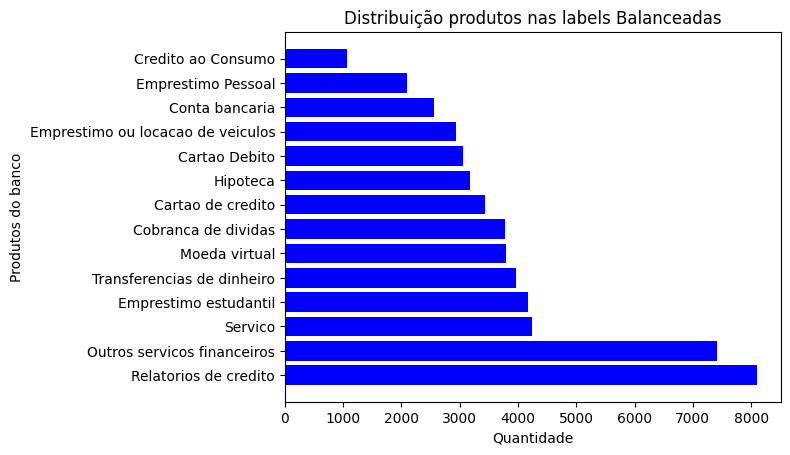

In [ ]:
# Verificando o balanceamento
df_balanceado_col = list_analise_label_col
lista_output = contagem_labels(df_balanceado_col, df_v2)

lista_output = pd.DataFrame(lista_output, columns=['Product', 'Qtd']).sort_values(by="Qtd", ascending=False)

plt.barh(lista_output['Product'], lista_output['Qtd'], color='blue')
plt.ylabel("Produtos do banco")
plt.xlabel("Quantidade")
plt.title("Distribuição produtos nas labels Balanceadas")
print(lista_output)
plt.show()

In [ ]:
lista_output.describe()

,Qtd
count,14.000000
mean,3841.214286
std,1874.489271
min,1065.000000
25%,2960.250000
50%,3604.000000
75%,4125.750000
max,8106.000000


In [ ]:
## Balancemaento de class UNDER-SAMPLING
for i in list_analise_label_col:
  mean_row = 2100
  desv_row = 200
  contagem = df_v2[i][df_v2[i] == 1].count()
  if contagem > (mean_row + desv_row):
    df_0 = df_v2[df_v2[i] == 0]
    df_1 = df_v2[df_v2[i] == 1]
    df_1 = df_1.sample(n=mean_row, random_state = 24)
    df_v2 = pd.concat([df_0, df_1], axis=0)
  validacao = df_v2[i][df_v2[i] == 1].count()
  print(f'Qtd ingressou: {contagem}. Qtd saiu: {validacao}')

Qtd ingressou: 8106. Qtd saiu: 2100
Qtd ingressou: 1935. Qtd saiu: 1935
Qtd ingressou: 2096. Qtd saiu: 2096
Qtd ingressou: 3436. Qtd saiu: 2100
Qtd ingressou: 1937. Qtd saiu: 1937
Qtd ingressou: 2561. Qtd saiu: 2100
Qtd ingressou: 3966. Qtd saiu: 2100
Qtd ingressou: 2013. Qtd saiu: 2013
Qtd ingressou: 2377. Qtd saiu: 2100
Qtd ingressou: 2931. Qtd saiu: 2100
Qtd ingressou: 3772. Qtd saiu: 2100
Qtd ingressou: 3170. Qtd saiu: 2100
Qtd ingressou: 4179. Qtd saiu: 2100
Qtd ingressou: 1065. Qtd saiu: 1065


In [ ]:
df_balanceado = df_v2.copy()
df_balanceado = df_balanceado.reset_index(drop=True)
df_balanceado.head(3)

,Date received,Consumer complaint narrative_clean,New_product_class_clean,Relatorios de credito,Outros servicos financeiros,Emprestimo Pessoal,Cartao de credito,Cartao Debito,Conta bancaria,Transferencias de dinheiro,Moeda virtual,Servico,Emprestimo ou locacao de veiculos,Cobranca de dividas,Hipoteca,Emprestimo estudantil,Credito ao Consumo
0,2023-04-27,Their website and statements do not tell me 1 ...,Emprestimo Pessoal,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2023-04-11,In of Tower Loan discriminated against myse...,Emprestimo Pessoal,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2023-03-10,I the consumer and natural person was denied c...,Emprestimo Pessoal,0,0,1,0,0,0,0,0,0,0,0,0,0,0


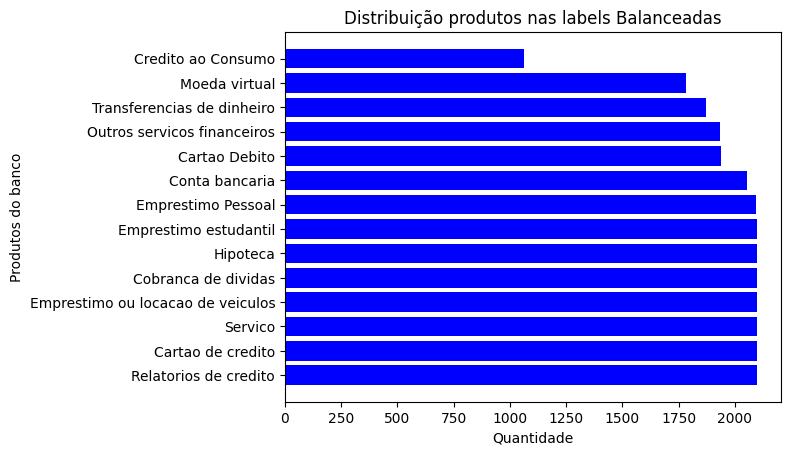

In [ ]:
# Verificando o balanceamento
df_balanceado_col = list_analise_label_col
lista_output = contagem_labels(df_balanceado_col, df_balanceado)

lista_output = pd.DataFrame(lista_output, columns=['Product', 'Qtd']).sort_values(by="Qtd", ascending=False)

plt.barh(lista_output['Product'], lista_output['Qtd'], color='blue')
plt.ylabel("Produtos do banco")
plt.xlabel("Quantidade")
plt.title("Distribuição produtos nas labels Balanceadas")

plt.show()

In [ ]:
#Zipando tadas as tags numa unica coluna
label_zip = list(zip(df_balanceado[list_analise_label_col[0]],
          df_balanceado[list_analise_label_col[1]],
          df_balanceado[list_analise_label_col[2]],
          df_balanceado[list_analise_label_col[3]],
          df_balanceado[list_analise_label_col[4]],
          df_balanceado[list_analise_label_col[5]],
          df_balanceado[list_analise_label_col[6]],
          df_balanceado[list_analise_label_col[7]],
          df_balanceado[list_analise_label_col[8]],
          df_balanceado[list_analise_label_col[9]],
          df_balanceado[list_analise_label_col[10]],
          df_balanceado[list_analise_label_col[11]],
          df_balanceado[list_analise_label_col[12]],
          df_balanceado[list_analise_label_col[13]],
          ))

df_balanceado['All_Tags'] = label_zip

In [ ]:
df_balanceado.tail()

,Date received,Consumer complaint narrative_clean,New_product_class_clean,Relatorios de credito,Outros servicos financeiros,Emprestimo Pessoal,Cartao de credito,Cartao Debito,Conta bancaria,Transferencias de dinheiro,Moeda virtual,Servico,Emprestimo ou locacao de veiculos,Cobranca de dividas,Hipoteca,Emprestimo estudantil,Credito ao Consumo,All_Tags
19881,2020-06-27,I attended University for 6 months I started ...,Emprestimo estudantil,0,0,0,0,0,0,0,0,0,0,0,0,1,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)"
19882,2017-04-21,I submitted an application for discharge with...,Emprestimo estudantil,0,0,0,0,0,0,0,0,0,0,0,0,1,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)"
19883,2020-03-24,In I was informed that because of my prior se...,Emprestimo estudantil,0,0,0,0,0,0,0,0,0,0,0,0,1,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)"
19884,2022-11-14,In I called my student loan servicer Nelnet t...,Emprestimo estudantil,0,0,0,0,0,0,0,0,0,0,0,0,1,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)"
19885,2016-11-18,I went from I never applied for loans direc...,Emprestimo estudantil,0,0,0,0,0,0,0,0,0,0,0,0,1,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)"


In [ ]:
df_balanceado.head(3)

,Date received,Consumer complaint narrative_clean,New_product_class_clean,Relatorios de credito,Outros servicos financeiros,Emprestimo Pessoal,Cartao de credito,Cartao Debito,Conta bancaria,Transferencias de dinheiro,Moeda virtual,Servico,Emprestimo ou locacao de veiculos,Cobranca de dividas,Hipoteca,Emprestimo estudantil,Credito ao Consumo,All_Tags
0,2023-04-27,Their website and statements do not tell me 1 ...,Emprestimo Pessoal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,"(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)"
1,2023-04-11,In of Tower Loan discriminated against myse...,Emprestimo Pessoal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,"(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)"
2,2023-03-10,I the consumer and natural person was denied c...,Emprestimo Pessoal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,"(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)"


In [ ]:
#Arquivo little (não PRECISA)
# df_balanceado.to_csv("/content/drive/MyDrive/estudo/Tesis-PUC/Text_bank_v3.csv", index=False)

df_balanceado = pd.read_csv("/content/drive/MyDrive/estudo/Tesis-PUC/Text_bank_v3.csv")

In [ ]:
# Deteção do registro com o texto maior
index_max = 0
max_valor = 0
for i in range(df_balanceado.shape[0]):
  valor_da_linha = len(str(df_balanceado['Consumer complaint narrative_clean'][i]))
  if max_valor < valor_da_linha :
    max_valor = valor_da_linha
    index_max = i
print(f"O maior texto tem: {max_valor} palavras, e esta no index: {index_max}")

O maior texto tem: 30463 palavras, e esta no index: 9530


In [ ]:
print(df_balanceado['Consumer complaint narrative_clean'][9530])

Office of the Consumer Financial Protection Bureau CFPB 1700 G Street NW Washington DC DC 20552 This is to complain against the Bank of America URGENCY HIGH IMPORTANCE HIGH WITHOUT PREJUDICE       I would like to draw your attention to    I had sent my complaint letter to Bank of America in which I clearly stated how this scam has affected me personally psychologically and financially I am afraid I have had to go through so much bureaucracy thus far in order to catch their attention to my concerns This really doesnt show their complaints department in a good light to say the least and certainly does not contribute tomyoverall satisfaction and peace of mind My complaint is against the bank that did not do its job properly could not preventforeseen fraud and could not conduct a proper investigation and not against the vulnerable customer who fell victim and lost all the savings due to the misconduct of the bank I feel very distressed and cheated all because no one took action immediately

In [ ]:
#Função para trução de texto

googletranslator_cfg = GoogleTranslator(source='en', target='pt')
# testo_pt = googletranslator_cfg.translate(texto_en)
# testo_pt
# translated_pt = googletranslator_cfg.translate_batch(list(df_balanceado['Consumer complaint narrative_clean']))
# df_balanceado['Consumer complaint narrative_clean_translated'] = translated_pt

def tradutor_en_es(texto_en):
  """
  Função que faze a tradução do ingles para o portugues,
  Insir texto e retorna a tradução
  """
  palavras_max = 500 #860
  googletranslator_cfg = GoogleTranslator(source='en', target='pt')
  #index_row += 1
  if len(texto_en) > palavras_max:
    lista_texto_pt = []
    qtd_particiones = round((len(texto_en)/palavras_max)+0.5)-1
    faixa_min = 0
    faixa_max= palavras_max
    for i in range(qtd_particiones):
      parte_n = " ".join(texto_en.split(" ")[faixa_min:faixa_max])
      #texto_pt = googletranslator_cfg.translate(parte_n)
      lista_texto_pt.append(parte_n)
      faixa_min += palavras_max
      if i+1 == qtd_particiones:
        faixa_max = -1
      else:
        faixa_max += palavras_max
    texto_pt = googletranslator_cfg.translate_batch(lista_texto_pt)
    texto_pt_final = " ".join(texto_pt)
    return texto_pt_final
    #print("executou")
  else:
    #print("erro")
    texto_pt_final = googletranslator_cfg.translate(texto_en)
    return texto_pt_final

In [ ]:
#Simulação de tradução do texto com maior tokens
inicio = time.time()
#Execução da função
texto_en = """Multi-step time series forecasting may be considered a type
              of multiple-output regression where a sequence of future values
              are predicted and each predicted value is dependent upon the
              prior values in the sequence."""
text_pt = tradutor_en_es(texto_en)
fim = time.time()
print(fim - inicio)
print(texto_en)
print(text_pt)

0.330005407333374
Multi-step time series forecasting may be considered a type
              of multiple-output regression where a sequence of future values
              are predicted and each predicted value is dependent upon the
              prior values in the sequence.
A previsão de séries temporais em várias etapas pode ser considerada um tipo
              de regressão de saída múltipla onde uma sequência de valores futuros
              são previstos e cada valor previsto depende do
              valores anteriores na sequência.


In [ ]:
df_balanceado.shape

(19886, 18)

In [ ]:
df_balanceado.tail()


,Date received,Consumer complaint narrative_clean,New_product_class_clean,Relatorios de credito,Outros servicos financeiros,Emprestimo Pessoal,Cartao de credito,Cartao Debito,Conta bancaria,Transferencias de dinheiro,Moeda virtual,Servico,Emprestimo ou locacao de veiculos,Cobranca de dividas,Hipoteca,Emprestimo estudantil,Credito ao Consumo,All_Tags
19881,2020-06-27,I attended University for 6 months I started ...,Emprestimo estudantil,0,0,0,0,0,0,0,0,0,0,0,0,1,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)"
19882,2017-04-21,I submitted an application for discharge with...,Emprestimo estudantil,0,0,0,0,0,0,0,0,0,0,0,0,1,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)"
19883,2020-03-24,In I was informed that because of my prior se...,Emprestimo estudantil,0,0,0,0,0,0,0,0,0,0,0,0,1,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)"
19884,2022-11-14,In I called my student loan servicer Nelnet t...,Emprestimo estudantil,0,0,0,0,0,0,0,0,0,0,0,0,1,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)"
19885,2016-11-18,I went from I never applied for loans direc...,Emprestimo estudantil,0,0,0,0,0,0,0,0,0,0,0,0,1,0,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)"


In [ ]:
# df_test = df_balanceado.copy()

In [ ]:
# df_balanceado = pd.read_csv("/content/drive/MyDrive/estudo/Tesis-PUC/Basev1/Text_bank_v4.csv")

In [ ]:
# Criando renge para fazer a tradução em batch
lista_limites = []
v1 = 0
v2 = 5000
for i in range(4):
  lista_limites.append((v1,v2))
  v1 += 5000
  if i == 2:
    v2 += df_balanceado.shape[0]-v1
  else:
    v2 += 5000
  # print(i)
print(lista_limites)
  #df_balanceado.iloc[10:20]


[(0, 5000), (5000, 10000), (10000, 15000), (15000, 19886)]


In [ ]:
lista_limites = lista_limites[3:]

In [ ]:
lista_limites

[(15000, 19886)]

In [ ]:
#####  Função Final Tradução de Texto para portuguese  #####
# df_balanceado['Consumer complaint narrative_clean_pt'] = '-'
for i,j in lista_limites:
  inicio = time.time()
  df_balanceado['Consumer complaint narrative_clean_pt'][i:j] = df_balanceado.iloc[i:j] \
   ['Consumer complaint narrative_clean'].apply(lambda x: tradutor_en_es(str(x)))
  #print(df_test.iloc[i:j]['Date received'].apply(lambda x: tradutor_en_es(x)))
  print(f"Executado: {i}")
  df_balanceado.to_csv("/content/drive/MyDrive/estudo/Tesis-PUC/Basev1/Text_bank_v4.csv", index=False)
  print(f'arquivo salvo: {i}')
  fim = time.time()
  print(f"Horas de execução {i}: {(((fim - inicio)/60)/60)}")
  print('-'*25)
  #print(j)

<ipython-input-10-d253ffe2891a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_balanceado['Consumer complaint narrative_clean_pt'][i:j] = df_balanceado.iloc[i:j] \


Executado: 15000
arquivo salvo: 15000
Horas de execução 15000: 2.1055336738295027
-------------------------


In [ ]:
df_balanceado = pd.read_csv("/content/drive/MyDrive/estudo/Tesis-PUC/Basev1/Text_bank_v4.csv")

In [ ]:
# Execução de Limpeza de Texto
# df_balanceado['Consumer complaint narrative_clean_pt'] = df_balanceado['Consumer complaint narrative_clean_pt'].\
                                            # apply(lambda x: limpeza_texto(str(x)))

df_balanceado['Consumer complaint narrative_clean_pt'] = df_balanceado['Consumer complaint narrative_clean_pt'].\
                                            apply(lambda x: str(x).lower())

In [ ]:
df_balanceado[df_balanceado['Consumer complaint narrative_clean_pt'] == '-']

,Date received,Consumer complaint narrative_clean,New_product_class_clean,Relatorios de credito,Outros servicos financeiros,Emprestimo Pessoal,Cartao de credito,Cartao Debito,Conta bancaria,Transferencias de dinheiro,Moeda virtual,Servico,Emprestimo ou locacao de veiculos,Cobranca de dividas,Hipoteca,Emprestimo estudantil,Credito ao Consumo,All_Tags,Consumer complaint narrative_clean_pt


In [ ]:
# Verificando a Tradução
df_balanceado[['Consumer complaint narrative_clean',	'Consumer complaint narrative_clean_pt']].tail()

,Consumer complaint narrative_clean,Consumer complaint narrative_clean_pt
19881,I attended University for 6 months I started ...,"estudei na universidade por 6 meses, comecei o..."
19882,I submitted an application for discharge with...,enviei um pedido de quitação com a nelnet. ten...
19883,In I was informed that because of my prior se...,"em fui informado que, por causa do meu serviço..."
19884,In I called my student loan servicer Nelnet t...,em liguei para meu gestor de empréstimos estud...
19885,I went from I never applied for loans direc...,eu passei de nunca solicitei empréstimos diret...


In [ ]:
df_balanceado.head()

,Date received,Consumer complaint narrative_clean,New_product_class_clean,Relatorios de credito,Outros servicos financeiros,Emprestimo Pessoal,Cartao de credito,Cartao Debito,Conta bancaria,Transferencias de dinheiro,Moeda virtual,Servico,Emprestimo ou locacao de veiculos,Cobranca de dividas,Hipoteca,Emprestimo estudantil,Credito ao Consumo,All_Tags,Consumer complaint narrative_clean_pt
0,2023-04-27,Their website and statements do not tell me 1 ...,Emprestimo Pessoal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,"(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",o site e os extratos deles não me informam 1 c...
1,2023-04-11,In of Tower Loan discriminated against myse...,Emprestimo Pessoal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,"(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",in of tower loan me discriminou ao decidir que...
2,2023-03-10,I the consumer and natural person was denied c...,Emprestimo Pessoal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,"(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)","eu, o consumidor e pessoa física, tive o crédi..."
3,2023-03-30,On Thursday at approximately hrs I was makin...,Emprestimo Pessoal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,"(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)","na quinta-feira, aproximadamente às horas, eu ..."
4,2023-05-02,Someone by the name of from Light Stream Loa...,Emprestimo Pessoal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,"(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",alguém chamado light stream loans me prometeu ...


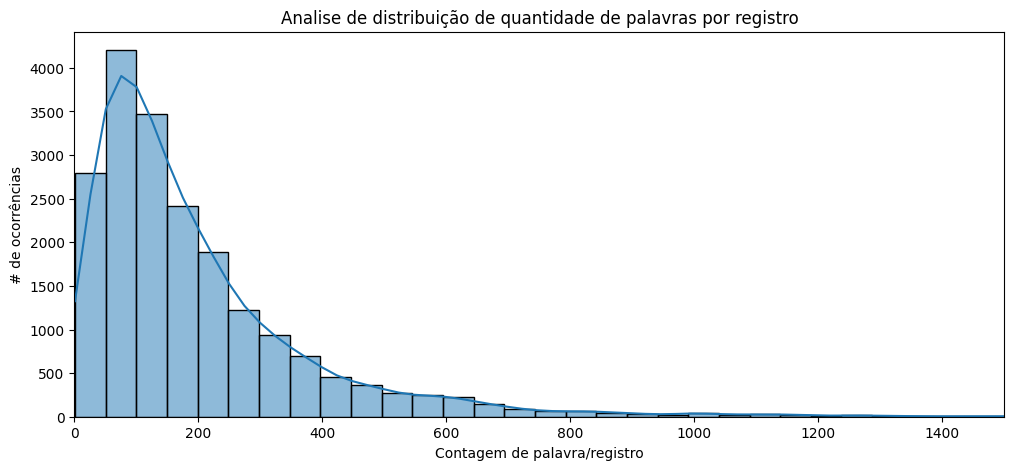

In [ ]:
# Analise de quantidade de palavras agrupados por registro
values_word = df_balanceado['Consumer complaint narrative_clean_pt'] \
            .apply(lambda x: len(x.split(" ")))
# max values = 5036
# min balues = 2
plt.figure (figsize=(12,5))
plt.xlim(0,1500)
plt.xlabel('Contagem de palavra/registro')
plt.ylabel('# de ocorrências')
plt.title("Analise de distribuição de quantidade de palavras por registro")
sn.histplot(values_word, bins=100, kde = True)
plt.show()

In [ ]:
238+152

390

In [ ]:
values_word.describe()

count    19886.000000
mean       202.683345
std        220.815575
min          1.000000
25%         75.000000
50%        141.000000
75%        253.000000
max       4946.000000
Name: Consumer complaint narrative_clean_pt, dtype: float64

<ipython-input-49-df3c876f6811>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_balanceado_corr = df_balanceado.corr()


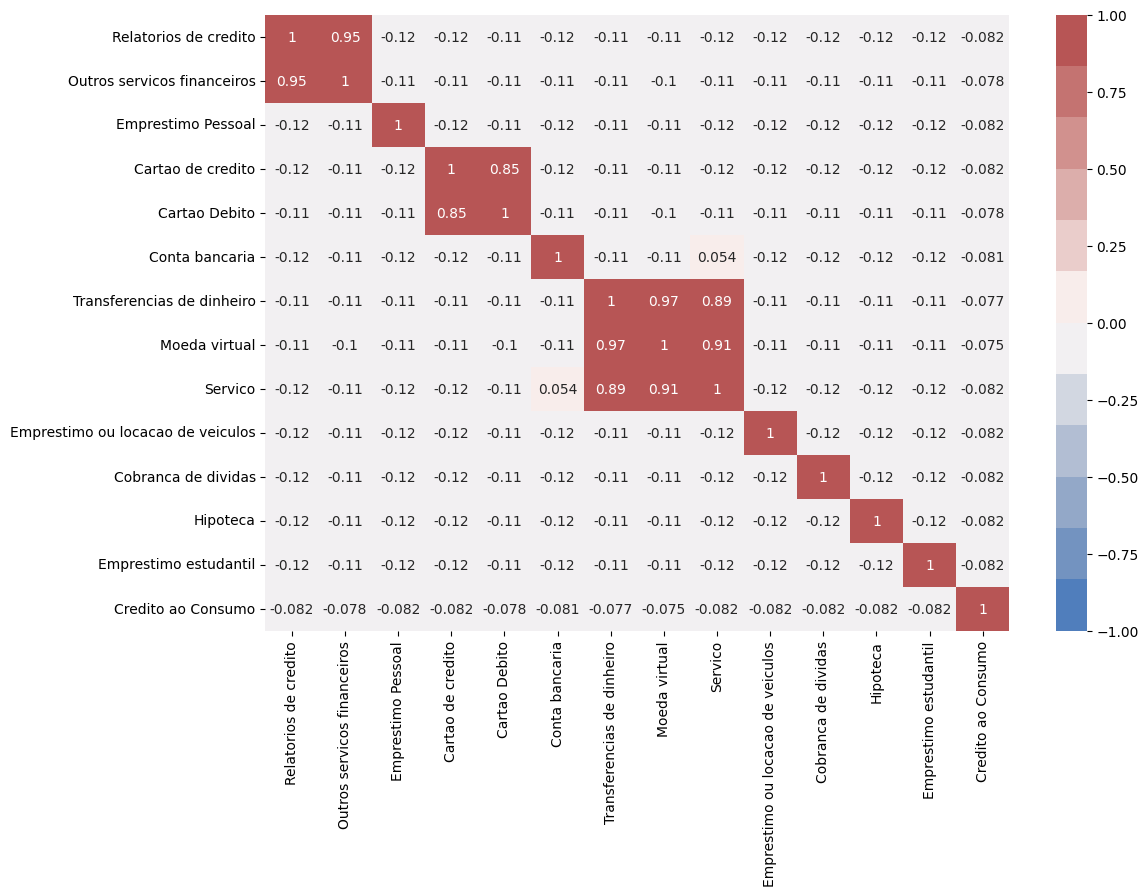

In [ ]:
## Calculo e analise de correlação
df_balanceado_corr = df_balanceado.corr()
plt.figure(figsize=(12, 8))
cmap = sn.color_palette("vlag", 12)
sn.heatmap(df_balanceado_corr, cmap=cmap, vmin=-1, vmax=1, annot=True) #cmap="Blues", "vlag"
plt.show()

Segundo o analise de correlação conseguimos identificar que temos alguns valores de labels estão fortemente correlacionados.
- A label de Moeda virtual tem uma forte correlação com a label Serviço, assim como serviço tem uma alta correlação com Transferencia de Dinheiro.
- A label de Cartão de Credito tem uma alta correlação com o Cartão de Debito
- A label Relatorios de Credito tem alta correlação com a label Outros Servicios Financeiros

## Modelagem e Inferência

In [ ]:
#Salvando em csv
# df_balanceado.to_csv("/content/drive/MyDrive/estudo/Tesis-PUC/Basev1/Text_bank_v5.csv", index=False)

In [4]:
df_balanceado = pd.read_csv("/content/drive/MyDrive/estudo/Tesis-PUC/Basev1/Text_bank_v5.csv")
# df_balanceado = pd.read_csv("/content/Text_bank_v5.csv")

#df_balanceado.drop(columns={'Unnamed: 0'},inplace=True)

In [5]:
df_balanceado = df_balanceado[['Date received', 'Consumer complaint narrative_clean_pt',
       'New_product_class_clean', 'Relatorios de credito',
       'Outros servicos financeiros', 'Emprestimo Pessoal',
       'Cartao de credito', 'Cartao Debito', 'Conta bancaria',
       'Transferencias de dinheiro', 'Moeda virtual', 'Servico',
       'Emprestimo ou locacao de veiculos', 'Cobranca de dividas', 'Hipoteca',
       'Emprestimo estudantil', 'Credito ao Consumo', 'All_Tags'
       ]]

In [6]:
df_balanceado.head(3)

,Date received,Consumer complaint narrative_clean_pt,New_product_class_clean,Relatorios de credito,Outros servicos financeiros,Emprestimo Pessoal,Cartao de credito,Cartao Debito,Conta bancaria,Transferencias de dinheiro,Moeda virtual,Servico,Emprestimo ou locacao de veiculos,Cobranca de dividas,Hipoteca,Emprestimo estudantil,Credito ao Consumo,All_Tags
0,2023-04-27,o site e os extratos deles não me informam 1 c...,Emprestimo Pessoal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,"(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)"
1,2023-04-11,in of tower loan me discriminou ao decidir que...,Emprestimo Pessoal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,"(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)"
2,2023-03-10,"eu, o consumidor e pessoa física, tive o crédi...",Emprestimo Pessoal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,"(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)"


In [7]:
# Particionamento dos dados para treino e teste
X_treino, X_test, y_treino, y_test = train_test_split(df_balanceado['Consumer complaint narrative_clean_pt'],
                                                      df_balanceado['All_Tags'],
                                                      test_size = 0.2,
                                                      random_state = 24)

In [8]:
#################################
# Modelo One Vs Rest Classifier #
#################################

In [9]:
# Baixar a lista de stopwords em português
nltk.download("stopwords")
# Definiendo as stop words de Portuguese
# stop_words = set(nltk.corpus.stopwords.words('portuguese'))
stop_words = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
# Utilização do metodo TF-IDF para vetorizar os textos
vetorizar = TfidfVectorizer(max_features=5000, max_df=0.85, lowercase=True, stop_words=stop_words, strip_accents='unicode')
# vetorizar = TfidfVectorizer(max_features=5000, lowercase=True, stop_words=stop_words)
vetorizar.fit(str(text) if text is not np.nan else "" for text in df_balanceado['Consumer complaint narrative_clean_pt'])
# vetorizar.fit(df_balanceado['Consumer complaint narrative_clean_pt'])
X_treino_tfidf = vetorizar.transform(str(text) if text is not np.nan else "" for text in X_treino)
X_test_tfidf   = vetorizar.transform(str(text) if text is not np.nan else "" for text in X_test)
print(X_treino_tfidf.shape)
print(X_test_tfidf.shape)

# (682392, 5000)
# (170598, 5000)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ate', 'eramos', 'estao', 'estavamos', 'estiveramos', 'estivessemos', 'foramos', 'fossemos', 'ha', 'hao', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'ja', 'nao', 'sao', 'sera', 'serao', 'seriamos', 'so', 'tambem', 'tera', 'terao', 'teriamos', 'tinhamos', 'tiveramos', 'tivessemos', 'voce', 'voces'] not in stop_words.
  warnings.warn(


(15908, 5000)
(3978, 5000)


In [11]:
X_treino_tfidf[:10].toarray().shape

(10, 5000)

In [12]:
#transformando as label zip em array
y_treino_array = np.asarray(list(y_treino))
y_test_array   = np.asarray(list(y_test))

In [13]:
# metodo 1: Relevancia Binaria => Um modelo binario para cada label
 # (quantidades de modelos é igual a quantidade de labels)

# Obs, não leva em consideração as relação entre as labels
solver    = 'newton-cg' #
iteracoes = 150
regressao_logistica = LogisticRegression(solver=solver, max_iter = iteracoes)
classificador_onevsrest = OneVsRestClassifier(estimator=regressao_logistica)
classificador_onevsrest.fit(X_treino_tfidf, y_treino_array)
resultado_onevsrest = classificador_onevsrest.score(X_test_tfidf, y_test_array)
print("Resultado: {0: .2f}%".format(resultado_onevsrest))

previsoes_OneVSRest_model_binarios = classificador_onevsrest.predict(X_test_tfidf)
# lbfgs -> 0.69
# newton-cholesky-> 0.69%
# Resultado:  0.79%


Resultado:  0.72%


In [18]:
#Verificando previsões
db_1 = previsoes_OneVSRest_model_binarios
db_2 = y_test_array
print(f'Um registro: {db_1[0]}')
print(f'Tipo de dado: {type(db_1)}')
print(f'Tamanho matriz: {db_1.shape}')
print('*'*50)
print(f'Um registro: {db_2[0]}')
print(f'Tipo de dado: {type(db_2)}')
print(f'Tamanho matriz: {db_2.shape}')

Um registro: (0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0)
Tipo de dado: <class 'numpy.ndarray'>
Tamanho matriz: (3978,)
**************************************************
Um registro: (0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0)
Tipo de dado: <class 'numpy.ndarray'>
Tamanho matriz: (3978,)


In [14]:
accuracy_multi = accuracy_score(y_test_array, previsoes_OneVSRest_model_binarios)
print("Acurácia Multirrótulo com OneVSRest: {0: .2f}%".format(accuracy_multi))

Acurácia Multirrótulo com OneVSRest:  0.72%


In [ ]:
# metrica para analisar cada label independientemente, baseado na distancia Hamming loss
# acuracia ou exact match = 1/3 ( 1 linha correta de 3 linhas)
# Hamming Loss = 3/12 (3 resultado correto de 12 resultados (4 label x 3linhas))


hamming_loss_onevsrest = hamming_loss(y_test_array,previsoes_OneVSRest_model_binarios)
print("Hamming Loss: {0: .2f}%".format(hamming_loss_onevsrest))
# Hamming Loss quanto mais perto de 0 é melhor
# Hamming Loss:  0.04%

Hamming Loss:  0.28%


In [ ]:
#  Relatório de classificação multirrótulo
print("Relatório de Classificação Multirrótulo OneVSRest:\n", classification_report(y_test_array, previsoes_OneVSRest_model_binarios))

Relatório de Classificação Multirrótulo OneVSRest:
                                             precision    recall  f1-score   support

(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)       0.39      0.06      0.10       197
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)       0.91      0.89      0.90       412
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)       0.90      0.93      0.91       438
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0)       0.69      0.76      0.72       426
(0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0)       0.64      0.77      0.70       425
(0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0)       0.00      0.00      0.00        25
(0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0)       0.76      0.79      0.77       359
(0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0)       0.66      0.79      0.72       370
(0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0)       0.00      0.00      0.00        58
(0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)       0.88      0.19      0.31        37
(0, 0, 0, 1, 0, 0, 0, 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#########################
#       Modelo Bert     #
#########################

df_treinamento = pd.merge(X_treino, y_treino, left_index=True, right_index=True)

In [ ]:
df_treinamento

,Consumer complaint narrative_clean_pt,All_Tags
14790,re analisar atentamente meu mandado formal esc...,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0)"
15224,essa dívida faz parte de uma ação coletiva con...,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0)"
6672,estou escrevendo para contestar a correspondên...,"(0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)"
7443,"olá, meu nome é, tenho um cartão de crédito co...","(0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)"
468,"eu nem me lembro das datas, mas eles continuam...","(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)"
...,...,...
6500,"depois de uma hora ao telefone com a comenity,...","(0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)"
19857,"pelo segundo ano consecutivo, enviei meus form...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)"
14528,recebi uma carta da portfolio recovery informa...,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0)"
899,estou escrevendo para sua agência na esperança...,"(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)"


In [ ]:
# Função para remover stop words de um texto
def remover_stop_words(texto):
    palavras = nltk.wordpunct_tokenize(texto)
    palavras_sem_stop_words = [palavra for palavra in palavras if palavra.lower() not in stop_words]
    return ' '.join(palavras_sem_stop_words)

df_treinamento['Consumer complaint narrative_clean_pt'] = df_treinamento \
 ['Consumer complaint narrative_clean_pt'].apply(lambda x: remover_stop_words(str(x)))

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
def Func_Tokenizar_Bert(dados, tamanho_maximo_texto):
  X_input_ids = np.zeros((len(dados),tamanho_maximo_texto))
  X_sttn_masks = np.zeros((len(dados),tamanho_maximo_texto))
  #Tokenizando vector com token pretreinado da bert
  for i, text in tqdm(enumerate(dados)):
    tokenized_text = tokenizer.encode_plus(
                        str(text) if text is not np.nan else "" ,
                        max_length=tamanho_maximo_texto,
                        truncation = True,
                        padding='max_length',
                        add_special_tokens=True,
                        return_tensors = 'tf'
      )
    X_input_ids[i,:] = tokenized_text.input_ids
    X_sttn_masks[i,:] = tokenized_text.attention_mask
  return X_input_ids, X_sttn_masks
  # print(i)
  # print(text)

In [ ]:
X_input_ids, X_sttn_masks = Func_Tokenizar_Bert(df_treinamento['Consumer complaint narrative_clean_pt'], 500)

0it [00:00, ?it/s]

In [ ]:
def Tranform_string_em_labels(valor):
  valor_formatado = [int(i.strip()) for i in str(valor).replace("(","").
                        replace(")","").split(sep=",")]
  return valor_formatado

In [ ]:
df_treinamento['All_Tags_format'] = df_treinamento['All_Tags'].map(Tranform_string_em_labels)

In [ ]:
 list_vetor_full_labels = [i for i in df_treinamento['All_Tags_format']]

In [ ]:

X_input_ids = tf.constant(X_input_ids, dtype='float64')
X_sttn_masks = tf.constant(X_sttn_masks, dtype='float64')

list_vetor_full_labels = tf.constant(list_vetor_full_labels, dtype='int64')


In [ ]:
## criando o dataset mais preciso e eficiente
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_sttn_masks, list_vetor_full_labels))

In [ ]:
def LabelDatasetMapFunction(input_ids, attn_mask, labels):
  return{
      'input_ids': input_ids,
      'attention_mask': attn_mask
        }, labels
        #list_vetor_full_labels

dataset = dataset.map(LabelDatasetMapFunction)

In [ ]:
## Criando lotes e embarulhar
dataset = dataset.shuffle(len(dataset))
# Quantidade de Batch a ser utilizado 32,64 ou 128, quanto menor capacidade
# de computação é melhor acrescentar o numero de batchs
dataset = dataset.batch(64,drop_remainder=True)

In [ ]:
# Tamanho de treino

p = 0.8
train_size = int((len(df_treinamento)//64)*p)

In [ ]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [ ]:
# 'bert-base-cased' => Considera as maiusculas e minusculas
# 'bert-base-uncased' => Considera todas as palavras como minuscula
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_model.trainabel = False

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# Congelando todas as camadas do modelo
for layer in bert_model.layers:
    layer.trainable = False

# Verificando se as camadas estão congeladas
for layer in bert_model.layers:
    print(layer.name, layer.trainable)

bert False


In [ ]:
bert_model

In [ ]:
input_ids = tf.keras.layers.Input(shape=(500,),name='input_ids', dtype='int32')
attention_masks = tf.keras.layers.Input(shape=(500,),name='attention_mask', dtype='int32')


bert_embds = bert_model.bert(input_ids, attention_mask = attention_masks)[1]
intemediaria_layer = tf.keras.layers.Dense(512, activation='relu', name='camada_intermediaria')(bert_embds)
output_layer = tf.keras.layers.Dense(14, activation='sigmoid', name='output_layer')(intemediaria_layer)

model = tf.keras.Model(inputs=[input_ids,attention_masks],outputs=output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 500)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 500)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 500, 7                                       

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate = 1e-5, weight_decay=1e-6)
# loss_func = tf.keras.losses.CategoricalCrossentropy()
loss_func = tf.keras.losses.BinaryCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
## Compilação e treinamento
model.compile(optimizer = optim, loss = loss_func, metrics= [acc])

In [ ]:
# Treinamento de rede neural
num_epochs = 5
hist = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = num_epochs
)

Epoch 1/5
198/198 [==============================] - 702s 3s/step - loss: 0.4864 - accuracy: 0.0201 - val_loss: 0.3412 - val_accuracy: 0.0675
Epoch 2/5
198/198 [==============================] - 709s 4s/step - loss: 0.3298 - accuracy: 0.0833 - val_loss: 0.3224 - val_accuracy: 0.1187
Epoch 3/5
198/198 [==============================] - 713s 4s/step - loss: 0.3234 - accuracy: 0.1102 - val_loss: 0.3206 - val_accuracy: 0.1497
Epoch 4/5
198/198 [==============================] - 699s 4s/step - loss: 0.3213 - accuracy: 0.1316 - val_loss: 0.3169 - val_accuracy: 0.1706
Epoch 5/5
198/198 [==============================] - 703s 4s/step - loss: 0.3196 - accuracy: 0.1446 - val_loss: 0.3173 - val_accuracy: 0.1569


In [ ]:
## Salvando historico de treinamento
caminho_a_salvar = "/content/Historico_fit_Bert.pkl"

with open(caminho_a_salvar, 'wb') as arquivo:
  pickle.dump(hist.history,arquivo)

## Carregando arquivo
with open(caminho_a_salvar, 'rb') as arquivo:
  historico = pickle.load(arquivo)

In [ ]:
# Tokenizando dados de Teste
X_input_ids_teste, X_sttn_masks_teste = Func_Tokenizar_Bert(X_test, 500)

0it [00:00, ?it/s]

In [ ]:
#Realizando as predições
previsoes_bert_model = model.predict({"input_ids" : X_input_ids_teste, "attention_mask" : X_sttn_masks_teste})

125/125 [==============================] - 163s 1s/step


In [ ]:
#transformando as labels
y_test_tr = y_test.map(Tranform_string_em_labels)

# Transformando a dimensão correta
array_y_test_tr = np.array(y_test_tr.to_list())
array_y_test_tr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [ ]:
#Verificando previsões
db_1 = previsoes_bert_model
db_2 = array_y_test_tr
print(f'Um registro: {db_1[0]}')
print(f'Tipo de dado: {type(db_1)}')
print(f'Tamanho matriz: {db_1.shape}')
print('*'*50)
print(f'Um registro: {db_2[0]}')
print(f'Tipo de dado: {type(db_2)}')
print(f'Tamanho matriz: {db_2.shape}')

Um registro: [0.10661983 0.09974179 0.06415206 0.08626488 0.08921485 0.0994311
 0.06760491 0.08204795 0.08507219 0.10256875 0.09300255 0.12333095
 0.14023346 0.04225761]
Tipo de dado: <class 'numpy.ndarray'>
Tamanho matriz: (3978, 14)
**************************************************
Um registro: [0 0 0 0 0 0 1 1 1 0 0 0 0 0]
Tipo de dado: <class 'numpy.ndarray'>
Tamanho matriz: (3978, 14)


In [ ]:
# Aplicar um limiar para converter probabilidades em rótulos binários (0 ou 1)
limiar = 0.15
previsoes_bert_model_binarios = tf.where(previsoes_bert_model > limiar, 1, 0)

In [ ]:
# metrica para analisar cada label independientemente, baseado na distancia Hamming loss
# acuracia ou exact match = 1/3 ( 1 linha correta de 3 linhas)
# Hamming Loss = 3/12 (3 resultado correto de 12 resultados (4 label x 3linhas))

#previsao_onevsrest = classificador_onevsrest.predict(X_test_tfidf)
hamming_loss_bert = hamming_loss(previsoes_bert_model_binarios, array_y_test_tr)
print("Hamming Loss: {0: .2f}%".format(hamming_loss_bert))
# Hamming Loss quanto mais perto de 0 é melhor
# Hamming Loss:  0.04%



Hamming Loss:  0.14%


In [ ]:
accuracy_multi = accuracy_score(array_y_test_tr, previsoes_bert_model_binarios)
print("Acurácia Multirrótulo com Bert: {0: .2f}%".format(accuracy_multi))

Acurácia Multirrótulo com Bert:  0.05%


In [ ]:
array_y_test_tr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [ ]:
previsoes_bert_model_binarios[10]

<tf.Tensor: shape=(14,), dtype=int32, numpy=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

In [ ]:
# Relatório de classificação multirrótulo
print("Relatório de Classificação Multirrótulo Roberta:\n", classification_report(array_y_test_tr, previsoes_bert_model_binarios))

Relatório de Classificação Multirrótulo Roberta:
               precision    recall  f1-score   support

           0       0.25      0.04      0.07       396
           1       0.19      0.03      0.05       369
           2       0.10      0.04      0.06       414
           3       0.10      0.02      0.03       417
           4       0.13      0.01      0.01       395
           5       0.03      0.01      0.01       428
           6       0.17      0.01      0.02       384
           7       0.13      0.03      0.04       359
           8       0.09      0.01      0.02       417
           9       0.11      0.02      0.04       425
          10       0.19      0.05      0.08       426
          11       0.18      0.15      0.16       438
          12       0.14      0.63      0.23       412
          13       0.00      0.00      0.00       197

   micro avg       0.14      0.08      0.10      5477
   macro avg       0.13      0.07      0.06      5477
weighted avg       0.13      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#########################
#     Modelo Roberta    #
#########################


# Carregar o tokenizer e o modelo RoBERTa pré-treinado para classificação
Tokens_Roberta = RobertaTokenizer.from_pretrained('roberta-base')
model_RoBerta = TFRobertaForSequenceClassification.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [ ]:
# Tokens_Roberta = tokenizer(textos, padding=True, truncation=True, return_tensors='tf')

def Func_Tokenizar_RoBert(dados, tamanho_maximo_texto):
  X_input_ids_RoBerta = np.zeros((len(dados),tamanho_maximo_texto))
  X_sttn_masks_RoBerta = np.zeros((len(dados),tamanho_maximo_texto))
  #Tokenizando vector com token pretreinado da bert
  for i, text in tqdm(enumerate(dados)):
    tokenized_text = Tokens_Roberta.encode_plus(
                        str(text) if text is not np.nan else "" ,
                        max_length=tamanho_maximo_texto,
                        truncation = True,
                        padding='max_length',
                        add_special_tokens=True,
                        return_tensors = 'tf'
      )
    X_input_ids_RoBerta[i,:] = tokenized_text.input_ids
    X_sttn_masks_RoBerta[i,:] = tokenized_text.attention_mask
  return X_input_ids_RoBerta, X_sttn_masks_RoBerta
  # print(i)
  # print(text)

In [ ]:
X_input_ids_RoBerta, X_sttn_masks_RoBerta = Func_Tokenizar_RoBert(df_treinamento['Consumer complaint narrative_clean_pt'], 500)

0it [00:00, ?it/s]

In [ ]:
def Tranform_string_em_labels(valor):
  valor_formatado = [int(i.strip()) for i in str(valor).replace("(","").
                        replace(")","").split(sep=",")]
  return valor_formatado

In [ ]:
df_treinamento['All_Tags_format'] = df_treinamento['All_Tags'].map(Tranform_string_em_labels)

In [ ]:
 list_vetor_full_labels = [i for i in df_treinamento['All_Tags_format']]

In [ ]:
# list_vetor_full_labels = np.array(list_vetor_full_labels)

X_input_ids_RoBerta = tf.constant(X_input_ids_RoBerta, dtype='float64')
X_sttn_masks_RoBerta = tf.constant(X_sttn_masks_RoBerta, dtype='float64')
# list_vetor_full_labels = tf.constant(np.array(list_vetor_full_labels), dtype='int64')
list_vetor_full_labels = tf.constant(list_vetor_full_labels, dtype='int64')
#list_vetor_full_labels = np.array(list_vetor_full_labels, dtype= np.int32)

# list_vetor_full_labels = tf.one_hot(list_vetor_full_labels, depth=2)
# list_vetor_full_labels = tf.constant(np.asarray(list_vetor_full_labels).reshape((-1,1)), dtype='int64')

In [ ]:
## criando o dataset mais preciso e eficiente
dataset_Roberta = tf.data.Dataset.from_tensor_slices((X_input_ids_RoBerta, X_sttn_masks_RoBerta, list_vetor_full_labels))

In [ ]:
#Função para agrupar em dictionarios
dataset_Roberta = dataset_Roberta.map(LabelDatasetMapFunction)

In [ ]:
## Criando lotes e embarulhar
dataset_Roberta = dataset_Roberta.shuffle(len(dataset_Roberta))
# Quantidade de Batch a ser utilizado 32,64 ou 128, quanto menor capacidade
# de computação é melhor acrescentar o numero de batchs
dataset_Roberta = dataset_Roberta.batch(64,drop_remainder=True)

In [ ]:
# Tamanho de treino
p = 0.8
train_size = int((len(df_treinamento)//64)*p)

In [ ]:
train_dataset_RoBerta = dataset_Roberta.take(train_size)
val_dataset_RoBerta = dataset_Roberta.skip(train_size)

In [ ]:
model_RoBerta.trainabel = False

In [ ]:
# Congelando todas as camadas do modelo
for layer in model_RoBerta.layers:
    layer.trainable = False

# Verificando se as camadas estão congeladas
for layer in model_RoBerta.layers:
    print(layer.name, layer.trainable)

roberta False
classifier False


In [ ]:
dataset_Roberta.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(64, 500), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(64, 500), dtype=tf.float64, name=None)}, TensorSpec(shape=(64, 14), dtype=tf.int64, name=None))>

In [ ]:
input_ids = tf.keras.layers.Input(shape=(500,),name='input_ids', dtype='int32')
attention_masks = tf.keras.layers.Input(shape=(500,),name='attention_mask', dtype='int32')


Roberta_embds = model_RoBerta([input_ids, attention_masks], training=False)
logits = Roberta_embds.logits
intemediaria_layer = tf.keras.layers.Dense(512, activation='relu', name='camada_intermediaria')(logits)

output_layer = tf.keras.layers.Dense(14, activation='sigmoid', name='output_layer')(intemediaria_layer)

model_RoBerta_summa = tf.keras.Model(inputs=[input_ids,attention_masks],outputs=output_layer)
model_RoBerta_summa.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 500)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 500)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_for_sequence_cl  TFSequenceClassifierOutput   1246471   ['input_ids[0][0]',           
 assification (TFRobertaFor  (loss=None, logits=(None,    70         'attention_mask[0][0]']      
 SequenceClassification)     2),                                                            

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate = 1e-5, weight_decay=1e-6)
# loss_func = tf.keras.losses.CategoricalCrossentropy()
loss_func = tf.keras.losses.BinaryCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
## Compilação e treinamento
model_RoBerta_summa.compile(optimizer = optim, loss = loss_func, metrics= [acc])

In [ ]:
# Treinamento de rede neural
num_epochs = 5
hist = model_RoBerta_summa.fit(
    train_dataset_RoBerta,
    validation_data = val_dataset_RoBerta,
    epochs = num_epochs
)

Epoch 1/5
198/198 [==============================] - 600s 3s/step - loss: 0.6873 - accuracy: 0.0949 - val_loss: 0.6842 - val_accuracy: 0.0809
Epoch 2/5
198/198 [==============================] - 596s 3s/step - loss: 0.6810 - accuracy: 0.0961 - val_loss: 0.6776 - val_accuracy: 0.0938
Epoch 3/5
198/198 [==============================] - 597s 3s/step - loss: 0.6741 - accuracy: 0.0903 - val_loss: 0.6704 - val_accuracy: 0.0891
Epoch 4/5
198/198 [==============================] - 596s 3s/step - loss: 0.6666 - accuracy: 0.0930 - val_loss: 0.6626 - val_accuracy: 0.1088
Epoch 5/5
198/198 [==============================] - 593s 3s/step - loss: 0.6582 - accuracy: 0.0912 - val_loss: 0.6537 - val_accuracy: 0.1053


In [ ]:
## Salvando historico de treinamento
caminho_a_salvar = "/content/Historico_fit_RoBerta.pkl"

with open(caminho_a_salvar, 'wb') as arquivo:
  pickle.dump(hist.history,arquivo)

## Carregando arquivo
with open(caminho_a_salvar, 'rb') as arquivo:
  historico = pickle.load(arquivo)

In [ ]:
# Tokenizando dados de Teste
X_input_ids_teste, X_sttn_masks_teste = Func_Tokenizar_Bert(X_test, 500)

0it [00:00, ?it/s]

In [ ]:
# Realizando as predições
previsoes_RoBerta_model = model_RoBerta_summa.predict({"input_ids" : X_input_ids_teste, "attention_mask" : X_sttn_masks_teste})

125/125 [==============================] - 155s 1s/step


In [ ]:
#transformando as labels
y_test_tr = y_test.map(Tranform_string_em_labels)

# Transformando a dimensão correta
array_y_test_tr = np.array(y_test_tr.to_list())
array_y_test_tr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [ ]:
#Verificando previsões
db_1 = previsoes_RoBerta_model
db_2 = array_y_test_tr
print(f'Um registro: {db_1[0]}')
print(f'Tipo de dado: {type(db_1)}')
print(f'Tamanho matriz: {db_1.shape}')
print('*'*50)
print(f'Um registro: {db_2[0]}')
print(f'Tipo de dado: {type(db_2)}')
print(f'Tamanho matriz: {db_2.shape}')

Um registro: [0.47181338 0.47065106 0.47088054 0.4747504  0.47299543 0.4745377
 0.48672727 0.47309983 0.4709545  0.47104698 0.4765412  0.47087002
 0.47780466 0.4758349 ]
Tipo de dado: <class 'numpy.ndarray'>
Tamanho matriz: (3978, 14)
**************************************************
Um registro: [0 0 0 0 0 0 1 1 1 0 0 0 0 0]
Tipo de dado: <class 'numpy.ndarray'>
Tamanho matriz: (3978, 14)


In [ ]:
# Aplicar um limiar para converter probabilidades em rótulos binários (0 ou 1)
limiar = 0.25
previsoes_Roberta_model_binarios = tf.where(previsoes_RoBerta_model > limiar, 1, 0)

In [ ]:
# metrica para analisar cada label independientemente, baseado na distancia Hamming loss
# acuracia ou exact match = 1/3 ( 1 linha correta de 3 linhas)
# Hamming Loss = 3/12 (3 resultado correto de 12 resultados (4 label x 3linhas))

#previsao_onevsrest = classificador_onevsrest.predict(X_test_tfidf)
hamming_loss_bert = hamming_loss(previsoes_Roberta_model_binarios, array_y_test_tr)
print("Hamming Loss: {0: .2f}%".format(hamming_loss_bert))
# Hamming Loss quanto mais perto de 0 é melhor
# Hamming Loss:  0.04%

##10

Hamming Loss:  0.90%


In [ ]:
accuracy_multi = accuracy_score(array_y_test_tr, previsoes_Roberta_model_binarios)
print("Acurácia Multirrótulo com Roberta: {0: .2f}%".format(accuracy_multi))

Acurácia Multirrótulo com Roberta:  0.00%


In [ ]:
# Relatório de classificação multirrótulo
print("Relatório de Classificação Multirrótulo Roberta:\n", classification_report(array_y_test_tr, previsoes_Roberta_model_binarios))

Relatório de Classificação Multirrótulo Roberta:
               precision    recall  f1-score   support

           0       0.10      1.00      0.18       396
           1       0.09      1.00      0.17       369
           2       0.10      1.00      0.19       414
           3       0.10      1.00      0.19       417
           4       0.10      1.00      0.18       395
           5       0.11      1.00      0.19       428
           6       0.10      1.00      0.18       384
           7       0.09      1.00      0.17       359
           8       0.10      1.00      0.19       417
           9       0.11      1.00      0.19       425
          10       0.11      1.00      0.19       426
          11       0.11      1.00      0.20       438
          12       0.10      1.00      0.19       412
          13       0.05      1.00      0.09       197

   micro avg       0.10      1.00      0.18      5477
   macro avg       0.10      1.00      0.18      5477
weighted avg       0.10      1

In [ ]:
#####################
#   Modelo GPT      #
#####################

# Carregar o tokenizer e o modelo GPT-2 pré-treinado
tokenizer_gpt = GPT2Tokenizer.from_pretrained('gpt2')
model_gpt =  TFGPT2Model.from_pretrained('gpt2')

All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [ ]:
# Tokenizar os textos
# tokens = tokenizer(textos, padding=True, truncation=True, return_tensors='tf')

tokenizer_gpt.add_special_tokens({'pad_token': '[PAD]'})

def Func_Tokenizar_GPT(dados, tamanho_maximo_texto):
  X_input_ids_GPT = np.zeros((len(dados),tamanho_maximo_texto))
  X_sttn_masks_GPT = np.zeros((len(dados),tamanho_maximo_texto))
  #Tokenizando vector com token pretreinado da bert
  for i, text in tqdm(enumerate(dados)):
    tokenized_text = tokenizer_gpt.encode_plus(
                        str(text) if text is not np.nan else "" ,
                        max_length=tamanho_maximo_texto,
                        truncation = True,
                        padding=True,
                        add_special_tokens=True,
                        return_tensors = 'tf'
      )
    X_input_ids_GPT[i,:tokenized_text.input_ids.shape[1]] = tokenized_text.input_ids
    X_sttn_masks_GPT[i,:tokenized_text.attention_mask.shape[1]] = tokenized_text.attention_mask
  return X_input_ids_GPT, X_sttn_masks_GPT
  # print(i)
  # print(text)

In [ ]:
X_input_ids_GPT, X_sttn_masks_GPT = Func_Tokenizar_GPT(df_treinamento['Consumer complaint narrative_clean_pt'], 500)

0it [00:00, ?it/s]

In [ ]:
df_treinamento['All_Tags_format'] = df_treinamento['All_Tags'].map(Tranform_string_em_labels)

In [ ]:
 list_vetor_full_labels = [i for i in df_treinamento['All_Tags_format']]

In [ ]:
# list_vetor_full_labels = np.array(list_vetor_full_labels)

X_input_ids_GPT = tf.constant(X_input_ids_GPT, dtype='float64')
X_sttn_masks_GPT = tf.constant(X_sttn_masks_GPT, dtype='float64')
# list_vetor_full_labels = tf.constant(np.array(list_vetor_full_labels), dtype='int64')
list_vetor_full_labels = tf.constant(list_vetor_full_labels, dtype='int64')
#list_vetor_full_labels = np.array(list_vetor_full_labels, dtype= np.int32)

# list_vetor_full_labels = tf.one_hot(list_vetor_full_labels, depth=2)
# list_vetor_full_labels = tf.constant(np.asarray(list_vetor_full_labels).reshape((-1,1)), dtype='int64')

In [ ]:
## criando o dataset mais preciso e eficiente
dataset_GPT = tf.data.Dataset.from_tensor_slices((X_input_ids_GPT, X_sttn_masks_GPT, list_vetor_full_labels))

In [ ]:
#Função para agrupar em dictionarios
dataset_GPT = dataset_GPT.map(LabelDatasetMapFunction)

In [ ]:
## Criando lotes e embarulhar
dataset_GPT = dataset_GPT.shuffle(len(dataset_GPT))
# Quantidade de Batch a ser utilizado 32,64 ou 128, quanto menor capacidade
# de computação é melhor acrescentar o numero de batchs
dataset_GPT = dataset_GPT.batch(64,drop_remainder=True)

In [ ]:
# Tamanho de treino
p = 0.8
train_size = int((len(df_treinamento)//64)*p)

In [ ]:
train_dataset_GPT = dataset_GPT.take(train_size)
val_dataset_GPT = dataset_GPT.skip(train_size)

In [ ]:
# Congelando todas as camadas do modelo
for layer in model_gpt.layers:
    layer.trainable = False

# Verificando se as camadas estão congeladas
for layer in model_gpt.layers:
    print(layer.name, layer.trainable)

transformer False


In [ ]:
input_ids = tf.keras.layers.Input(shape=(500,),name='input_ids', dtype='int32')
attention_masks = tf.keras.layers.Input(shape=(500,),name='attention_mask', dtype='int32')


# GPT_embds = model_gpt(input_ids, attention_mask = attention_masks)[1]
# GPT_embds = model_gpt([input_ids,  attention_masks])[1]
GPT_outputs = model_gpt(input_ids, attention_mask=attention_masks)
GPT_embds = GPT_outputs['last_hidden_state']
# GPT_hidden_states = GPT_outputs['hidden_states']


logits = tf.keras.layers.Flatten()(GPT_embds)
# intemediaria_layer = tf.keras.layers.Dense(512, activation='relu', name='camada_intermediaria')(logits)

output_layer = tf.keras.layers.Dense(14, activation='sigmoid', name='output_layer')(logits)

model_GPT_summa = tf.keras.Model(inputs=[input_ids,attention_masks],outputs=output_layer)
model_GPT_summa.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 500)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 500)]                0         []                            
 )                                                                                                
                                                                                                  
 tfgpt2_model (TFGPT2Model)  TFBaseModelOutputWithPastA   1244398   ['input_ids[0][0]',           
                             ndCrossAttentions(last_hid   08         'attention_mask[0][0]']      
                             den_state=(None, 500, 768)                                       

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate = 1e-5, weight_decay=1e-6)
# loss_func = tf.keras.losses.CategoricalCrossentropy()
loss_func = tf.keras.losses.BinaryCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
## Compilação e treinamento
model_GPT_summa.compile(optimizer = optim, loss = loss_func, metrics= [acc])

In [ ]:
# Treinamento de rede neural
num_epochs = 5
hist = model_GPT_summa.fit(
    train_dataset_GPT,
    validation_data = val_dataset_GPT,
    epochs = num_epochs
)

Epoch 1/5
198/198 [==============================] - 763s 4s/step - loss: 0.6903 - accuracy: 0.1170 - val_loss: 0.3965 - val_accuracy: 0.1903
Epoch 2/5
198/198 [==============================] - 843s 4s/step - loss: 0.4240 - accuracy: 0.2005 - val_loss: 0.3288 - val_accuracy: 0.3272
Epoch 3/5
198/198 [==============================] - 822s 4s/step - loss: 0.3891 - accuracy: 0.2487 - val_loss: 0.2982 - val_accuracy: 0.3856
Epoch 4/5
198/198 [==============================] - 754s 4s/step - loss: 0.3635 - accuracy: 0.2862 - val_loss: 0.2872 - val_accuracy: 0.4025
Epoch 5/5
198/198 [==============================] - 777s 4s/step - loss: 0.3391 - accuracy: 0.3198 - val_loss: 0.2585 - val_accuracy: 0.4069


In [ ]:
# Tokenizando dados de Teste
X_input_ids_teste, X_sttn_masks_teste = Func_Tokenizar_GPT(X_test, 500)

0it [00:00, ?it/s]

In [ ]:
# Realizando as predições
previsoes_GPT_model = model_GPT_summa.predict({"input_ids" : X_input_ids_teste, "attention_mask" : X_sttn_masks_teste})

125/125 [==============================] - 184s 1s/step


In [ ]:
#transformando as labels
y_test_tr = y_test.map(Tranform_string_em_labels)

# Transformando a dimensão correta
array_y_test_tr = np.array(y_test_tr.to_list())
array_y_test_tr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [ ]:
#Verificando previsões
db_1 = previsoes_GPT_model
db_2 = array_y_test_tr
print(f'Um registro: {db_1[0]}')
print(f'Tipo de dado: {type(db_1)}')
print(f'Tamanho matriz: {db_1.shape}')
print('*'*50)
print(f'Um registro: {db_2[0]}')
print(f'Tipo de dado: {type(db_2)}')
print(f'Tamanho matriz: {db_2.shape}')

Um registro: [6.30463066e-04 9.20070242e-03 4.70926845e-03 4.24188474e-04
 6.22087345e-02 4.03901003e-02 5.66524446e-01 6.67182878e-02
 9.15188432e-01 8.69813561e-03 1.86281785e-01 1.10996105e-01
 6.52840734e-02 1.89198684e-02]
Tipo de dado: <class 'numpy.ndarray'>
Tamanho matriz: (3978, 14)
**************************************************
Um registro: [0 0 0 0 0 0 1 1 1 0 0 0 0 0]
Tipo de dado: <class 'numpy.ndarray'>
Tamanho matriz: (3978, 14)


In [ ]:
# Aplicar um limiar para converter probabilidades em rótulos binários (0 ou 1)
limiar = 0.45
previsoes_GPT_model_binarios = tf.where(previsoes_GPT_model > limiar, 1, 0)

In [ ]:
# metrica para analisar cada label independientemente, baseado na distancia Hamming loss
# acuracia ou exact match = 1/3 ( 1 linha correta de 3 linhas)
# Hamming Loss = 3/12 (3 resultado correto de 12 resultados (4 label x 3linhas))

#previsao_onevsrest = classificador_onevsrest.predict(X_test_tfidf)
hamming_loss_GPT = hamming_loss(array_y_test_tr, previsoes_GPT_model_binarios )
print("Hamming Loss: {0: .2f}%".format(hamming_loss_GPT))
# Hamming Loss quanto mais perto de 0 é melhor
# Hamming Loss:  0.04%

##10

Hamming Loss:  0.11%


In [ ]:
accuracy_multi = accuracy_score(array_y_test_tr, previsoes_GPT_model_binarios)
print("Acurácia Multirrótulo com GPT: {0: .2f}%".format(accuracy_multi))

Acurácia Multirrótulo com Roberta:  0.09%


In [ ]:
# Relatório de classificação multirrótulo
print("Relatório de Classificação Multirrótulo Roberta:\n", classification_report(array_y_test_tr, previsoes_GPT_model_binarios))

Relatório de Classificação Multirrótulo Roberta:
               precision    recall  f1-score   support

           0       0.63      0.15      0.24       396
           1       0.60      0.08      0.13       369
           2       0.28      0.11      0.16       414
           3       0.45      0.21      0.28       417
           4       0.34      0.25      0.29       395
           5       0.33      0.19      0.24       428
           6       0.40      0.31      0.35       384
           7       0.42      0.27      0.33       359
           8       0.34      0.38      0.36       417
           9       0.29      0.07      0.12       425
          10       0.39      0.08      0.14       426
          11       0.60      0.20      0.30       438
          12       0.39      0.44      0.41       412
          13       0.06      0.01      0.02       197

   micro avg       0.39      0.20      0.27      5477
   macro avg       0.39      0.20      0.24      5477
weighted avg       0.41      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
## Salvando historico de treinamento
import pickle

caminho_a_salvar = "/content/Historico_fit_GPT.pkl"

with open(caminho_a_salvar, 'wb') as arquivo:
  pickle.dump(historico_GPT,arquivo)

## Carregando arquivo
with open(caminho_a_salvar, 'rb') as arquivo:
  historico = pickle.load(arquivo)


In [5]:
#########################
# Comparação de modelos #
#########################

## Carregando arquivo de history's
historico_Bert_caminho = '/content/Historico_fit_Bert.pkl'
historico_RoBerta_caminho = '/content/Historico_fit_GPT.pkl'
historico_GPT_caminho = '/content/Historico_fit_RoBerta.pkl'

with open(historico_Bert_caminho, 'rb') as arquivo:
  historico_Bert = pickle.load(arquivo)

with open(historico_RoBerta_caminho, 'rb') as arquivo:
  historico_RoBerta = pickle.load(arquivo)

with open(historico_GPT_caminho, 'rb') as arquivo:
  historico_GPT = pickle.load(arquivo)

In [6]:
df_loss_RN = pd.DataFrame({'loss_Bert':historico_Bert['loss'],
              'val_loss_Bert':historico_Bert['val_loss'],
              'loss_RoBerta':historico_RoBerta['loss'],
              'val_loss_RoBerta':historico_RoBerta['val_loss'],
              'loss_GPT':historico_GPT['loss'],
              'val_loss_GPT':historico_GPT['val_loss']
              })

In [7]:
df_accuravy_RN = pd.DataFrame({'accuracy_Bert':historico_Bert['accuracy'],
              'val_val_accuracy_Bert':historico_Bert['val_accuracy'],
              'accuracy_RoBerta':historico_RoBerta['accuracy'],
              'val_val_accuracy_RoBerta':historico_RoBerta['val_accuracy'],
              'accuracy_GPT':historico_GPT['accuracy'],
              'val_val_accuracy_GPT':historico_GPT['val_accuracy']
              })

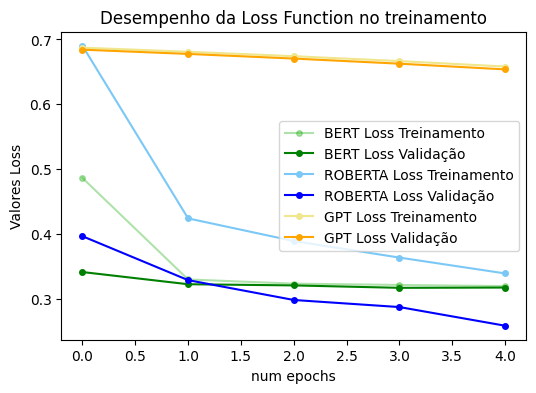

In [19]:
# visualizing losses and accuracy #FFA500
# train_loss = hist.history['loss']
# val_loss   = hist.history['val_loss']
# train_acc  = hist.history['accuracy']
# val_acc    = hist.history['val_accuracy']
xc         = range(5)

plt.figure(figsize=(6,4))
plt.plot(xc, df_loss_RN['accuracy_Bert'], label="BERT Loss Treinamento", marker='o', markersize=4, color="#11aa0055")
plt.plot(xc, df_loss_RN['val_loss_Bert'], label="BERT Loss Validação", marker='o', markersize=4, color="#008000")
plt.plot(xc, df_loss_RN['loss_RoBerta'], label="ROBERTA Loss Treinamento", marker='o', markersize=4, color="#7BC8F6")
plt.plot(xc, df_loss_RN['val_loss_RoBerta'], label="ROBERTA Loss Validação", marker='o', markersize=4, color="#0000FF")
plt.plot(xc, df_loss_RN['loss_GPT'], label="GPT Loss Treinamento", marker='o', markersize=4, color="#F0E68C")
plt.plot(xc, df_loss_RN['val_loss_GPT'], label="GPT Loss Validação", marker='o', markersize=4, color="#FFA500")
plt.ylabel("Valores Loss")
plt.xlabel("num epochs")
plt.title("Desempenho da Loss Function no treinamento")
plt.legend()
plt.show()



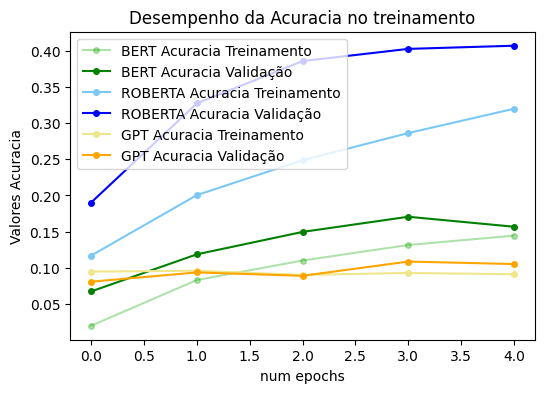

In [22]:
xc  = range(5)

plt.figure(figsize=(6,4))
plt.plot(xc, df_accuravy_RN['accuracy_Bert'], label="BERT Acuracia Treinamento", marker='o', markersize=4, color="#11aa0055")
plt.plot(xc, df_accuravy_RN['val_val_accuracy_Bert'], label="BERT Acuracia Validação", marker='o', markersize=4, color="#008000")
plt.plot(xc, df_accuravy_RN['accuracy_RoBerta'], label="ROBERTA Acuracia Treinamento", marker='o', markersize=4, color="#7BC8F6")
plt.plot(xc, df_accuravy_RN['val_val_accuracy_RoBerta'], label="ROBERTA Acuracia Validação", marker='o', markersize=4, color="#0000FF")
plt.plot(xc, df_accuravy_RN['accuracy_GPT'], label="GPT Acuracia Treinamento", marker='o', markersize=4, color="#F0E68C")
plt.plot(xc, df_accuravy_RN['val_val_accuracy_GPT'], label="GPT Acuracia Validação", marker='o', markersize=4, color="#FFA500")
plt.ylabel("Valores Acuracia")
plt.xlabel("num epochs")
plt.title("Desempenho da Acuracia no treinamento")
plt.legend()
plt.show()

## Modelo Com Melhor Performance

In [3]:
###################################
#  Modelo com melhor performance  #
###################################

df_balanceado = pd.read_csv("/content/Text_bank_v5.csv")

df_balanceado = df_balanceado[['Date received', 'Consumer complaint narrative_clean_pt',
       'New_product_class_clean', 'Relatorios de credito',
       'Outros servicos financeiros', 'Emprestimo Pessoal',
       'Cartao de credito', 'Cartao Debito', 'Conta bancaria',
       'Transferencias de dinheiro', 'Moeda virtual', 'Servico',
       'Emprestimo ou locacao de veiculos', 'Cobranca de dividas', 'Hipoteca',
       'Emprestimo estudantil', 'Credito ao Consumo', 'All_Tags'
       ]]

# Particionamento dos dados para treino e teste
X_treino, X_test, y_treino, y_test = train_test_split(df_balanceado['Consumer complaint narrative_clean_pt'],
                                                      df_balanceado['All_Tags'],
                                                      test_size = 0.2,
                                                      random_state = 24)

# Baixar a lista de stopwords em português
nltk.download("stopwords")
# Definiendo as stop words de Portuguese
# stop_words = set(nltk.corpus.stopwords.words('portuguese'))
stop_words = nltk.corpus.stopwords.words('portuguese')

# Utilização do metodo TF-IDF para vetorizar os textos
vetorizar = TfidfVectorizer(max_features=5000, max_df=0.85, lowercase=True, stop_words=stop_words, strip_accents='unicode')
# vetorizar = TfidfVectorizer(max_features=5000, lowercase=True, stop_words=stop_words)
vetorizar.fit(str(text) if text is not np.nan else "" for text in df_balanceado['Consumer complaint narrative_clean_pt'])
# vetorizar.fit(df_balanceado['Consumer complaint narrative_clean_pt'])
X_treino_tfidf = vetorizar.transform(str(text) if text is not np.nan else "" for text in X_treino)
X_test_tfidf   = vetorizar.transform(str(text) if text is not np.nan else "" for text in X_test)
print(X_treino_tfidf.shape)
print(X_test_tfidf.shape)

# (682392, 5000)
# (170598, 5000)

#transformando as label zip em array
y_treino_array = np.asarray(list(y_treino))
y_test_array   = np.asarray(list(y_test))


solver    = 'newton-cg' #
iteracoes = 150
regressao_logistica = LogisticRegression(solver=solver, max_iter = iteracoes)
classificador_onevsrest = OneVsRestClassifier(estimator=regressao_logistica)
classificador_onevsrest.fit(X_treino_tfidf, y_treino_array)
resultado_onevsrest = classificador_onevsrest.score(X_test_tfidf, y_test_array)
print("Resultado: {0: .2f}%".format(resultado_onevsrest))

previsoes_OneVSRest_model_binarios = classificador_onevsrest.predict(X_test_tfidf)
# lbfgs -> 0.69
# newton-cholesky-> 0.69%
# Resultado:  0.79%


hamming_loss_onevsrest = hamming_loss(y_test_array,previsoes_OneVSRest_model_binarios)
print("Hamming Loss: {0: .2f}%".format(hamming_loss_onevsrest))

#  Relatório de classificação multirrótulo
print("Relatório de Classificação Multirrótulo OneVSRest:\n", classification_report(y_test_array, previsoes_OneVSRest_model_binarios))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ate', 'eramos', 'estao', 'estavamos', 'estiveramos', 'estivessemos', 'foramos', 'fossemos', 'ha', 'hao', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'ja', 'nao', 'sao', 'sera', 'serao', 'seriamos', 'so', 'tambem', 'tera', 'terao', 'teriamos', 'tinhamos', 'tiveramos', 'tivessemos', 'voce', 'voces'] not in stop_words.
  warnings.warn(


(3432, 5000)
(859, 5000)
Resultado:  0.73%
Hamming Loss:  0.27%
Relatório de Classificação Multirrótulo OneVSRest:
                                             precision    recall  f1-score   support

(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)       0.80      0.47      0.59       233
(0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)       1.00      0.39      0.56        41
(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)       0.68      0.92      0.78       402
(0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)       0.00      0.00      0.00         1
(1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)       0.00      0.00      0.00        18
(1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)       0.80      0.82      0.81       164

                                  accuracy                           0.73       859
                                 macro avg       0.55      0.43      0.46       859
                              weighted avg       0.74      0.73      0.71       859



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [5]:
##########################################################
# Salvando modelo preditivo serializado como produto final
##########################################################

caminho_modelo_escolhido = 'OnevsRest_modelo_escolhido.pkl'
with open(caminho_modelo_escolhido, 'wb') as file:
    pickle.dump(classificador_onevsrest, file)